# Read the data

In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from transformers import BertTokenizer, TFBertModel

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

import spacy
nlp = spacy.load("en_core_web_sm")

import re
import requests

In [65]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('Twitterdatainsheets_new.csv')
df

C:\Users\xnguyen\AppData\Local\Temp\ipykernel_19000\297950735.py:2: DtypeWarning:

Columns (3,4,5,6,12,14) have mixed types. Specify dtype option on import or set low_memory=False.



,index,TweetID,Weekday,Hour,Day,Lang,IsReshare,Reach,RetweetCount,Likes,Klout,Sentiment,text,LocationID,UserID
0,0,tw-682712873332805633,Thursday,17,31,en,False,44.0,0.0,0.0,35.0,0.0,We are hiring: Senior Software Engineer - Prot...,3751.0,tw-40932430
1,1,tw-682713045357998080,Thursday,17,31,en,True,1810.0,5.0,0.0,53.0,2.0,RT @CodeMineStatus: This is true Amazon Web Se...,3989.0,tw-3179389829
2,2,tw-682713219375476736,Thursday,17,31,en,False,282.0,0.0,0.0,47.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ub...,3741.0,tw-4624808414
3,3,tw-682713436967579648,Thursday,17,31,en,False,2087.0,4.0,0.0,53.0,0.0,Happy New Year to all those AWS instances of o...,3753.0,tw-356447127
4,4,tw-682714048199311366,Thursday,17,31,en,False,953.0,0.0,0.0,47.0,0.0,Amazon is hiring! #Sr. #International Tax Mana...,3751.0,tw-3172686669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206290,206290,tw-443876086,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206291,206291,tw-565013710,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206292,206292,tw-322341885,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
206293,206293,tw-3304550634,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preparation & Feature Engineering

Project Objective:

The goal of our project is to predict tweet engagement based on the text of the tweets. As a part of this, we will remove the existing sentiment data because we plan to extract sentiment directly from the tweet text rather than using pre-calculated sentiment values.

Klout is a metric that measures user influence. Klout and reach is highly correlated with engagement. Since it is too closely related to the target variable (engagement), we have decided to remove the Klout and reach from our dataset to avoid data leakage, ensuring that our model doesn't inadvertently use information that directly predicts engagement.

In [66]:
# Remove leading/trailing whitespace in column names
df.columns = df.columns.str.strip()
df = df.dropna(subset=['text'])
# Drop unwanted columns
columns_to_drop = ['index', 'LocationID', 'UserID', 'Klout', 'Sentiment','Reach']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [67]:
# Calculate the engagement score based on reweetcount and likes
df['engagement_score'] = df['RetweetCount'] + df['Likes']
df.head()

,TweetID,Weekday,Hour,Day,Lang,IsReshare,RetweetCount,Likes,text,engagement_score
0,tw-682712873332805633,Thursday,17,31,en,False,0.0,0.0,We are hiring: Senior Software Engineer - Prot...,0.0
1,tw-682713045357998080,Thursday,17,31,en,True,5.0,0.0,RT @CodeMineStatus: This is true Amazon Web Se...,5.0
2,tw-682713219375476736,Thursday,17,31,en,False,0.0,0.0,Devops Engineer Aws Ansible Cassandra Mysql Ub...,0.0
3,tw-682713436967579648,Thursday,17,31,en,False,4.0,0.0,Happy New Year to all those AWS instances of o...,4.0
4,tw-682714048199311366,Thursday,17,31,en,False,0.0,0.0,Amazon is hiring! #Sr. #International Tax Mana...,0.0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   TweetID           100000 non-null  object 
 1   Weekday           100000 non-null  object 
 2   Hour              100000 non-null  object 
 3   Day               100000 non-null  object 
 4   Lang              100000 non-null  object 
 5   IsReshare         100000 non-null  object 
 6   RetweetCount      100000 non-null  float64
 7   Likes             100000 non-null  float64
 8   text              100000 non-null  object 
 9   engagement_score  100000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 8.4+ MB


In [69]:
# Focusing on English tweets only
df = df[df['Lang'] == 'en'].reset_index(drop=True)

In [70]:
# Feature engineering
df['num_hashtags'] = df['text'].str.count(r'#\w+')
df['num_mentions'] = df['text'].str.count(r'@\w+')
df['num_urls'] = df['text'].str.count(r'http|www')
df['num_questions'] = df['text'].str.count(r'\?')
df['num_exclamations'] = df['text'].str.count(r'!')

In [71]:
# Clean and normalize text
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    #additionaly: remove trailing and leading blanks; note that you can also remove multiple white spaces using regex
    doc = doc.strip()
    # Remove URLs
    doc = re.sub(r'http\S+', '', doc)
    
    # Remove mentions and hashtags
    doc = re.sub(r'@[A-Za-z0-9_]+', '', doc)
    doc = re.sub(r'#[A-Za-z0-9_]+', '', doc)

    # tokenize document
    tokens = word_tokenize(doc)
    # remove numbers
    tokens = [token for token in tokens if not token.isnumeric()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

df["text"] = [normalize_document(r) for r in df["text"]]

In [72]:
# pip install bertopic sentence-transformers

In [73]:
# Using BERtopic for topic extraction

from bertopic import BERTopic

# Get the tweet texts
docs = df['text'].astype(str).tolist()

# Initialize and fit BERTopic
topic_model = BERTopic()
topics, _ = topic_model.fit_transform(docs)

# Add topics to DataFrame
df['topic'] = topics

In [74]:
df.head(3)

,TweetID,Weekday,Hour,Day,Lang,IsReshare,RetweetCount,Likes,text,engagement_score,num_hashtags,num_mentions,num_urls,num_questions,num_exclamations,topic
0,tw-682712873332805633,Thursday,17,31,en,False,0.0,0.0,hiring senior software engineer proto job awsc...,0.0,6,1,2,1,0,124
1,tw-682713045357998080,Thursday,17,31,en,True,5.0,0.0,rt codeminestatus true amazon web service php ...,5.0,8,1,1,0,0,242
2,tw-682713219375476736,Thursday,17,31,en,False,0.0,0.0,devops engineer aws ansible cassandra mysql ub...,0.0,4,0,2,0,0,120


In [75]:
# Feature engineering
df['char_count'] = df['text'].apply(len)
df['polarity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity) # Extract polarity
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity) # Extract subjectivity
df['is_weekend'] = df['Weekday'].apply(lambda x: 1 if x in ['Sunday','Saturday'] else 0)
df['is_workhour'] = df['Hour'].astype(int).apply(lambda x: 1 if 9 <= x <= 17 else 0)
df['has_call_to_action'] = df['text'].str.contains(r'\b(apply|check|read|click|visit|learn)\b', case=False).astype(int)

In [76]:
# Make sentiment segmentation
def sentiment(score):
 if score < 0:
  return 'Negative'
 elif score == 0:
  return 'Neutral'
 else:
  return 'Positive'
df['sentiment'] = df['polarity'].apply(sentiment)
tweets = pd.get_dummies(df, columns=['sentiment'], prefix='Is')

In [77]:
def hour_bin(h):
    if 5 <= h < 12: return 'morning'
    elif 12 <= h < 17: return 'afternoon'
    elif 17 <= h < 21: return 'evening'
    else: return 'night'

df['hour_bin'] = df['Hour'].astype(int).apply(hour_bin)

In [78]:
# One-hot encode Weekday, Hour, Day, and Hour Bin
weekday_dummies = pd.get_dummies(df['Weekday'], prefix='is_weekday').astype(int)
hour_dummies = pd.get_dummies(df['Hour'], prefix='is_hour').astype(int)
day_dummies = pd.get_dummies(df['Day'], prefix='is_day').astype(int)
hour_bin_dummies = pd.get_dummies(df['hour_bin'], prefix='is').astype(int)

# Add them back to the main DataFrame
df = pd.concat([df, weekday_dummies, hour_dummies, day_dummies, hour_bin_dummies], axis=1)

In [79]:
column_to_drop = ['Weekday','Hour','Day','hour_bin','Lang']
df = df.drop(columns = column_to_drop)
df.head(3)

,TweetID,IsReshare,RetweetCount,Likes,text,engagement_score,num_hashtags,num_mentions,num_urls,num_questions,num_exclamations,topic,char_count,polarity,subjectivity,is_weekend,is_workhour,has_call_to_action,sentiment,is_weekday_Friday,is_weekday_Monday,is_weekday_Saturday,is_weekday_Sunday,is_weekday_Thursday,is_weekday_Tuesday,is_weekday_Wednesday,is_hour_0,is_hour_1,is_hour_2,is_hour_3,is_hour_4,is_hour_5,is_hour_6,is_hour_7,is_hour_8,is_hour_9,is_hour_10,is_hour_11,is_hour_12,is_hour_13,is_hour_14,is_hour_15,is_hour_16,is_hour_17,is_hour_18,is_hour_19,is_hour_20,is_hour_21,is_hour_22,is_hour_23,is_hour_0,is_hour_1,is_hour_10,is_hour_11,is_hour_12,is_hour_13,is_hour_14,is_hour_15,is_hour_16,is_hour_17,is_hour_18,is_hour_19,is_hour_2,is_hour_20,is_hour_21,is_hour_22,is_hour_23,is_hour_3,is_hour_4,is_hour_5,is_hour_6,is_hour_7,is_hour_8,is_hour_9,is_day_1,is_day_2,is_day_3,is_day_4,is_day_5,is_day_6,is_day_7,is_day_8,is_day_9,is_day_10,is_day_11,is_day_12,is_day_13,is_day_14,is_day_15,is_day_16,is_day_17,is_day_18,is_day_19,is_day_20,is_day_21,is_day_22,is_day_23,is_day_24,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_30,is_day_31,is_day_1,is_day_10,is_day_11,is_day_12,is_day_13,is_day_14,is_day_15,is_day_16,is_day_17,is_day_18,is_day_19,is_day_2,is_day_20,is_day_21,is_day_22,is_day_23,is_day_24,is_day_25,is_day_26,is_day_27,is_day_28,is_day_29,is_day_3,is_day_30,is_day_31,is_day_4,is_day_5,is_day_6,is_day_7,is_day_8,is_day_9,is_afternoon,is_evening,is_morning,is_night
0,tw-682712873332805633,False,0.0,0.0,hiring senior software engineer proto job awsc...,0.0,6,1,2,1,0,124,93,0.00,0.00,0,1,0,Neutral,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,tw-682713045357998080,True,5.0,0.0,rt codeminestatus true amazon web service php ...,5.0,8,1,1,0,0,242,93,0.35,0.65,0,1,0,Positive,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,tw-682713219375476736,False,0.0,0.0,devops engineer aws ansible cassandra mysql ub...,0.0,4,0,2,0,0,120,98,0.00,0.00,0,1,0,Neutral,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [80]:
df.to_csv("basetable.csv", index=False)

# Data analysis

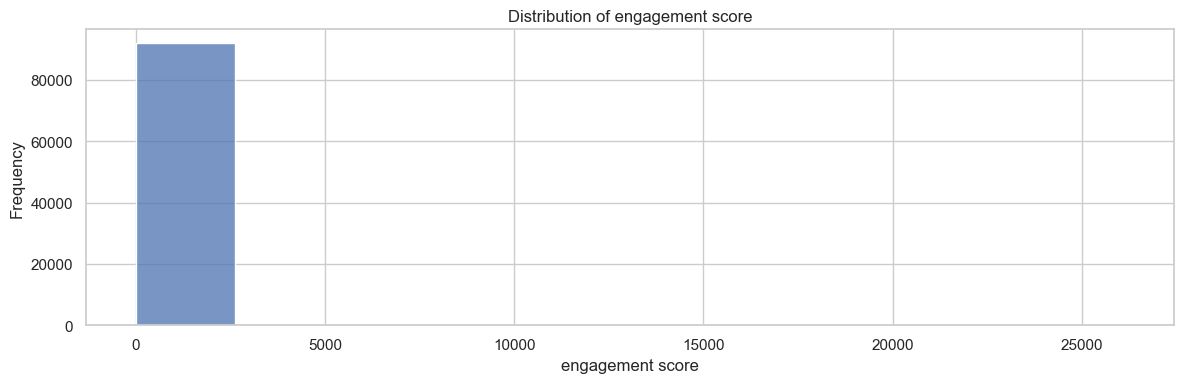

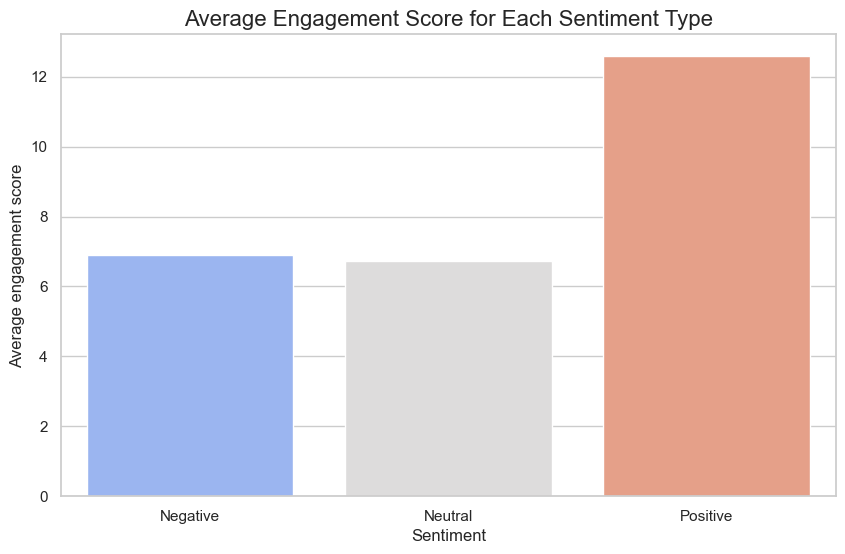

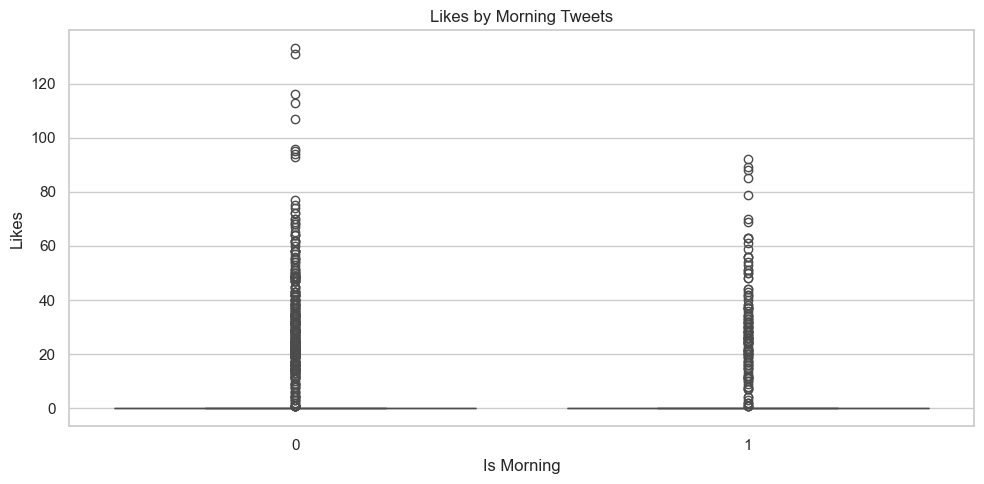

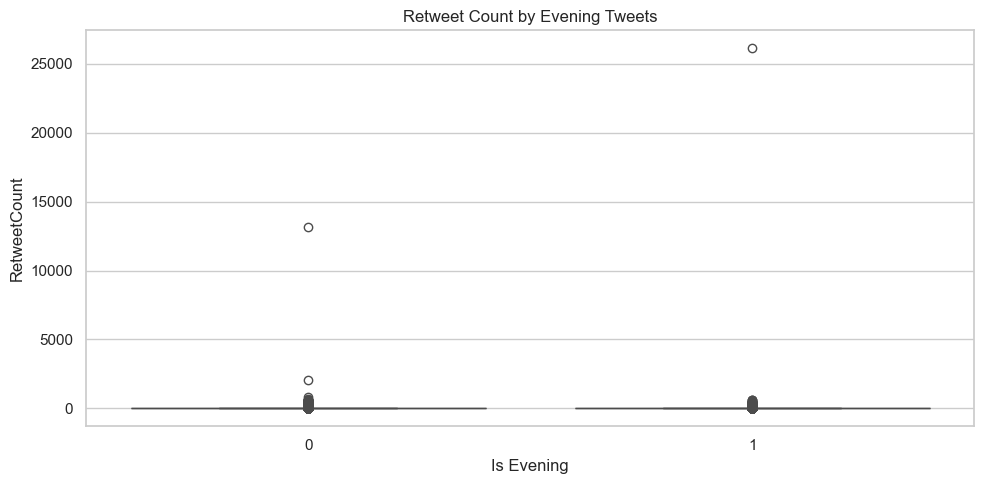

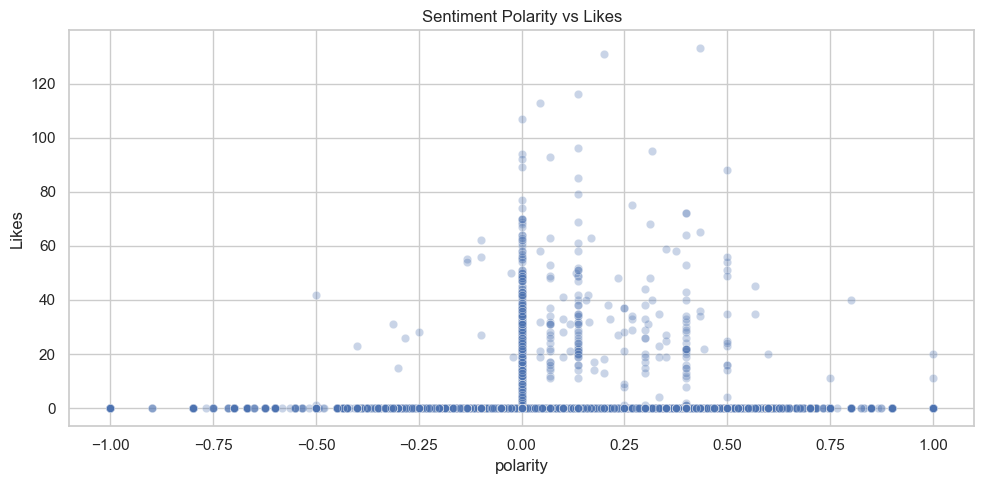

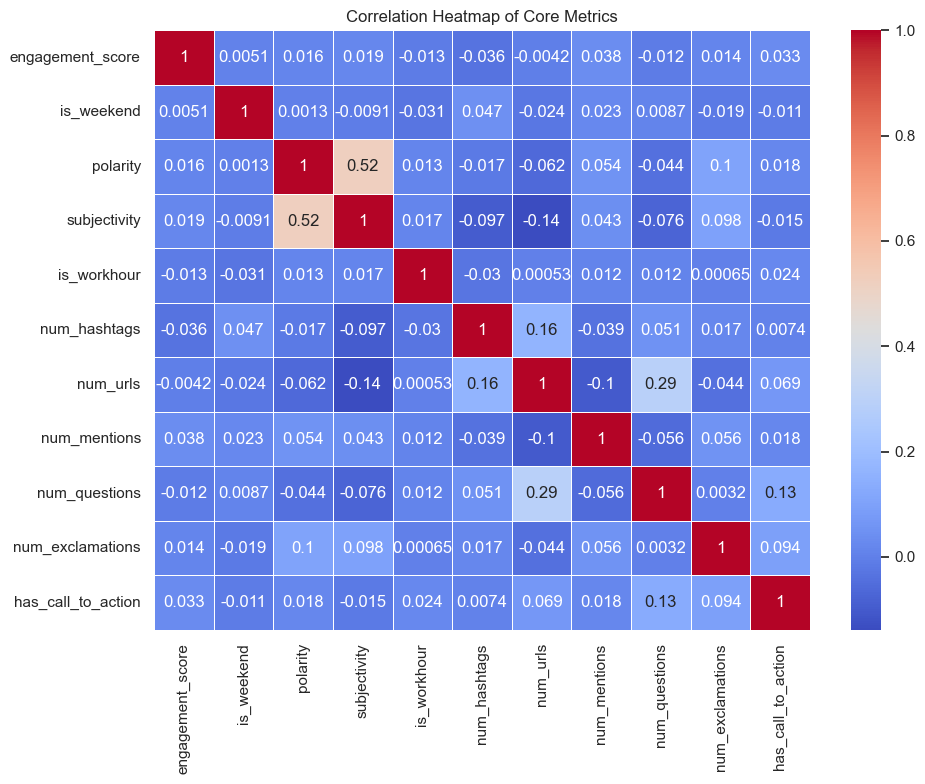

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# ---------- HISTOGRAMS ----------

# Likes Distribution
plt.figure(figsize=(12, 4))
sns.histplot(df['engagement_score'], bins=10)
plt.title('Distribution of engagement score')
plt.xlabel('engagement score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# The average engagement score in for each sentiment type

average_likes = df.groupby('sentiment')['engagement_score'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='sentiment', y='engagement_score', data=average_likes, palette='coolwarm')
plt.title('Average Engagement Score for Each Sentiment Type', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Average engagement score', fontsize=12)
plt.show()

# ---------- BOXPLOTS ----------

# Likes by Morning Tweets
plt.figure(figsize=(10, 5))
sns.boxplot(x='is_morning', y='Likes', data=df)
plt.title('Likes by Morning Tweets')
plt.xlabel('Is Morning')
plt.tight_layout()
plt.show()

# Retweet Count by Evening Tweets
plt.figure(figsize=(10, 5))
sns.boxplot(x='is_evening', y='RetweetCount', data=df)
plt.title('Retweet Count by Evening Tweets')
plt.xlabel('Is Evening')
plt.tight_layout()
plt.show()

# ---------- SENTIMENT VS ENGAGEMENT ----------

# Polarity vs Likes
plt.figure(figsize=(10, 5))
sns.scatterplot(x='polarity', y='Likes', data=df, alpha=0.3)
plt.title('Sentiment Polarity vs Likes')
plt.tight_layout()
plt.show()

# ---------- CORRELATION HEATMAP ----------

plt.figure(figsize=(10, 8))
corr_matrix = df[['engagement_score','is_weekend', 'polarity', 'subjectivity','is_workhour','num_hashtags','num_urls','num_mentions','num_questions','num_exclamations','has_call_to_action']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Core Metrics")
plt.tight_layout()
plt.show()

- The correlation heatmap revealed that most features had very weak linear relationships with the target variable engagement_score, suggesting that engagement is influenced by more complex, nonlinear interactions.
- The strongest correlation observed was between polarity and subjectivity (0.52), which is expected as more opinionated tweets tend to carry clearer sentiment.
- Features like num_mentions (0.038) and has_call_to_action (0.033) showed slightly higher correlations with engagement, but still remained weak. These results support the use of tree-based models like Random Forest, which are better suited to capturing subtle patterns and interactions that linear models might miss.

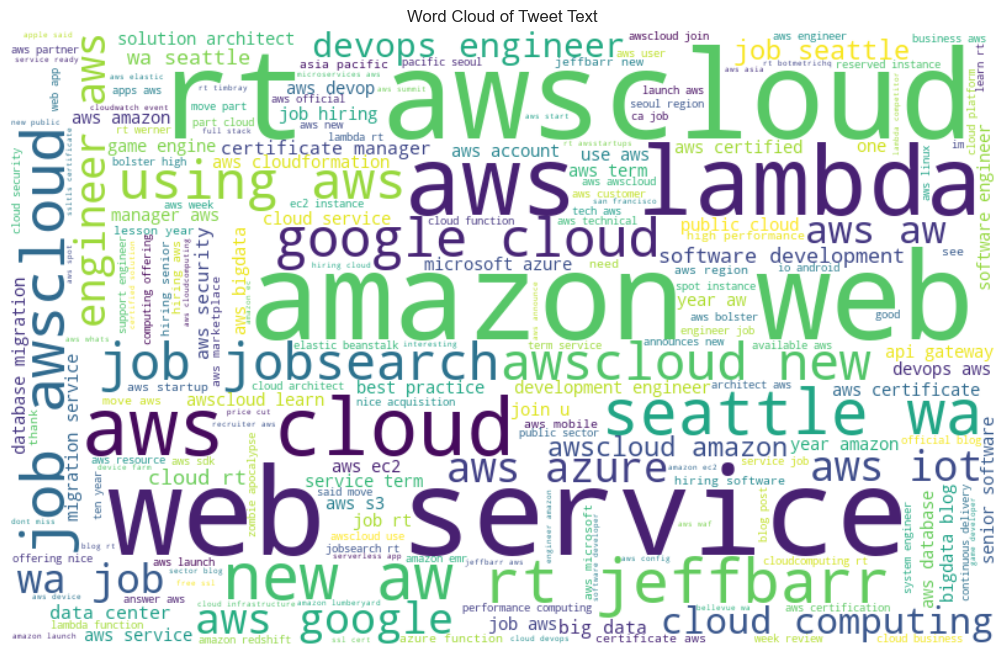

In [82]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text from all tweets in bin 1
all_text = ' '.join([word for word in df['text']])

# Create a WordCloud
wordcloud = WordCloud(width=800, height=500, background_color='white', random_state=42, max_font_size=100).generate(all_text)

# Display the WordCloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

From word cloud visulization, we can see that:
The word cloud suggests a focus on:

Cloud services including AWS, Google Cloud, and Microsoft Azure.

Job opportunities in cloud computing and related fields.

Specific technical aspects, such as AWS Lambda, EC2 instances, and API gateway.

The focus on the Seattle region, which is a tech hub, especially for Amazon-related jobs

# Modeling

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91886 entries, 0 to 91885
Columns: 140 entries, TweetID to is_night
dtypes: float64(5), int32(122), int64(9), object(4)
memory usage: 55.4+ MB


### Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import numpy as np
import pandas as pd

# Reuse previous features and log-transformed target
df['log_engagement'] = np.log1p(df['engagement_score'])
y = df['log_engagement']
X = df.drop(columns=['text', 'engagement_score', 'log_engagement', 'RetweetCount', 'Likes', 'TweetID'], errors='ignore')
X = X.select_dtypes(include='number')

# Define model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
neg_mae = make_scorer(mean_absolute_error, greater_is_better=False)

# Evaluate
r2_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2')
rmse_scores = cross_val_score(rf_model, X, y, cv=cv, scoring=neg_rmse)
mae_scores = cross_val_score(rf_model, X, y, cv=cv, scoring=neg_mae)

# Package results
rf_results = {
    'Model': 'RandomForestRegressor',
    'R2 (mean)': r2_scores.mean(),
    'RMSE (mean)': -rmse_scores.mean(),
    'MAE (mean)': -mae_scores.mean()
}

# Display
print(pd.DataFrame([rf_results]))

                   Model  R2 (mean)  RMSE (mean)  MAE (mean)
0  RandomForestRegressor   0.730557     0.659182    0.418077


### Gradient Boosting

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Define model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_rmse = make_scorer(mean_squared_error, squared=False, greater_is_better=False)
neg_mae = make_scorer(mean_absolute_error, greater_is_better=False)

# Evaluate
r2_scores = cross_val_score(gbr_model, X, y, cv=cv, scoring='r2')
rmse_scores = cross_val_score(gbr_model, X, y, cv=cv, scoring=neg_rmse)
mae_scores = cross_val_score(gbr_model, X, y, cv=cv, scoring=neg_mae)

# Package results
gbr_results = {
    'Model': 'GradientBoostingRegressor',
    'R2 (mean)': r2_scores.mean(),
    'RMSE (mean)': -rmse_scores.mean(),
    'MAE (mean)': -mae_scores.mean()
}

# Display
print(pd.DataFrame([gbr_results]))

                       Model  R2 (mean)  RMSE (mean)  MAE (mean)
0  GradientBoostingRegressor   0.465445     0.928589    0.654722
